In [197]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

class MoannaDataset(Dataset):
    def __init__(self, data_file, label_file):
        self.data = pd.read_csv(data_file, sep=',', header=0, index_col=0).values
        self.label = pd.read_csv(label_file, header=0, index_col=0).values[:,1]
        self.data = torch.from_numpy(self.data).float().to(device)
        self.label = self.label.astype(int)
        self.label = torch.from_numpy(self.label).long().to(device)

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]


class MoannaModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super(MoannaModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        # self.t = nn.Tanh()
        self.dropout = nn.Dropout(dropout)
        # self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # self.relu1 = nn.ReLU()
        # self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        # out = self.batchnorm(out)
        out = self.relu(out)
        # out = self.t(out)
        out = self.dropout(out)
        # out = self.fc3(out)
        # out = self.relu1(out)
        # out = self.dropout1(out)
        out = self.fc2(out)
        return out

In [2]:

data_file = '/home/intern/WarmUpProject/p-tcga_binary_mutation.csv'
label_file = '/home/intern/WarmUpProject/pp-TCGA-clinical.csv'

dataset = MoannaDataset(data_file, label_file)



In [37]:
batch_size = 256


In [38]:
idx = torch.randperm(len(dataset))

split_point = int(0.7 * len(idx))

train_idx = list(idx[:split_point])
test_idx = list(idx[split_point:])

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 


In [39]:
len(train_dataset)

7028

In [40]:
train_dataset[7000][0]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')

In [41]:
len(train_dataset[0][0])

13322

In [137]:
def k_fold_cross_validation(train_dataset, test_loader, k, num_epochs, batch_size, learning_rate, hidden_dim, device, shuffle=True):
    
    n_samples = len(train_dataset)
    fold_size = n_samples // k
    indices = np.random.permutation(n_samples)

    Model = []
    Train_acc = []
    Val_acc = []
    Test_acc = []
    
    for i in range(k):
        print(f"Processing fold {i+1}/{k}...")
        
        start = i * fold_size
        end = (i + 1) * fold_size
        
        traintrain_indices = list(np.concatenate([indices[:start], indices[end:]]))
        trainval_indices = list(indices[start:end])
        
        # Create data loaders for training and validation
        traintrain_dataset = Subset(train_dataset, traintrain_indices)
        trainval_dataset = Subset(train_dataset, trainval_indices)
        traintrain_loader = DataLoader(traintrain_dataset, batch_size=batch_size, shuffle=shuffle)
        trainval_loader = DataLoader(trainval_dataset, batch_size=batch_size, shuffle=False)    
        
        # Hyperparameters
        # learning_rate = 0.1
        # hidden_dim = 512

        # Initialize model and transfer to GPU
        model = MoannaModel(len(train_dataset[0][0]), hidden_dim, 33).to(device)
        

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        
        # Train the model
        train_losses = []
        train_accs = []
        val_accs = []
        test_accs = []
        
        for epoch in range(num_epochs):
            # Train
            model.train()
            train_loss = 0.0
            train_acc = 0.0
            for j, (inputs, labels) in enumerate(traintrain_loader):
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())

            train_loss /= len(traintrain_loader)
            train_acc /= len(traintrain_loader)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            # Validate
            model.eval()
            val_acc = 0.0
            with torch.no_grad():
                for inputs, labels in trainval_loader:
                    outputs = model(inputs)
                    val_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())
                val_acc /= len(trainval_loader)
                val_accs.append(val_acc)

            # # Check if this is the best model so far
            # if val_acc > best_accuracy:
            #     best_accuracy = val_acc
            #     best_model = model.__class__(train_dataset.data.shape[1], hidden_dim, 33).to(device)
            #     best_model.load_state_dict(model.state_dict())
                
            # Test
            model.eval()
            test_acc = 0.0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    test_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())
                test_acc /= len(test_loader)
                test_accs.append(test_acc)
                
            print(f"Fold {i+1}/{k}, Epoch {epoch+1}: Train Loss={train_loss:.4f}, "
                  f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Test Acc={test_acc:.4f}")
            
        MModel = model.__class__(len(train_dataset[0][0]), hidden_dim, 33).to(device)
        MModel.load_state_dict(model.state_dict())
        Model.append(MModel)
        
        Train_acc.append(train_accs[-1])
        Val_acc.append(val_accs[-1])
        Test_acc.append(test_accs[-1])
        
        # Plot loss and accuracy for this fold
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.legend()
        plt.title(f"Fold {i+1} Loss")

        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Acc')
        plt.plot(val_accs, label='Val Acc')
        plt.plot(test_accs, label='Test Acc')
        plt.legend()
        plt.title(f"Fold {i+1} Accuracy")
        plt.show()

    return Model, Train_acc, Val_acc, Test_acc

Processing fold 1/5...
Fold 1/5, Epoch 1: Train Loss=3.3832, Train Acc=0.1112, Val Acc=0.1495, Test Acc=0.1379
Fold 1/5, Epoch 2: Train Loss=3.1782, Train Acc=0.1668, Val Acc=0.1671, Test Acc=0.1588
Fold 1/5, Epoch 3: Train Loss=3.0354, Train Acc=0.1974, Val Acc=0.1894, Test Acc=0.1786
Fold 1/5, Epoch 4: Train Loss=2.8963, Train Acc=0.2318, Val Acc=0.2116, Test Acc=0.1975
Fold 1/5, Epoch 5: Train Loss=2.7589, Train Acc=0.2674, Val Acc=0.2495, Test Acc=0.2430
Fold 1/5, Epoch 6: Train Loss=2.6130, Train Acc=0.3220, Val Acc=0.2895, Test Acc=0.2844
Fold 1/5, Epoch 7: Train Loss=2.4678, Train Acc=0.3685, Val Acc=0.3065, Test Acc=0.3070
Fold 1/5, Epoch 8: Train Loss=2.3173, Train Acc=0.3988, Val Acc=0.3208, Test Acc=0.3264
Fold 1/5, Epoch 9: Train Loss=2.1706, Train Acc=0.4480, Val Acc=0.3725, Test Acc=0.3623
Fold 1/5, Epoch 10: Train Loss=2.0374, Train Acc=0.5257, Val Acc=0.4079, Test Acc=0.4152
Fold 1/5, Epoch 11: Train Loss=1.9129, Train Acc=0.5759, Val Acc=0.4151, Test Acc=0.4213
Fold 1/

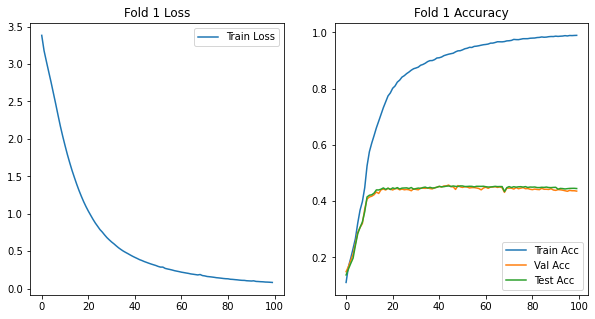

Processing fold 2/5...
Fold 2/5, Epoch 1: Train Loss=3.3888, Train Acc=0.1158, Val Acc=0.1457, Test Acc=0.1411
Fold 2/5, Epoch 2: Train Loss=3.1770, Train Acc=0.1622, Val Acc=0.1581, Test Acc=0.1617
Fold 2/5, Epoch 3: Train Loss=3.0237, Train Acc=0.2031, Val Acc=0.1809, Test Acc=0.1890
Fold 2/5, Epoch 4: Train Loss=2.8806, Train Acc=0.2428, Val Acc=0.2130, Test Acc=0.2139
Fold 2/5, Epoch 5: Train Loss=2.7313, Train Acc=0.2795, Val Acc=0.2437, Test Acc=0.2358
Fold 2/5, Epoch 6: Train Loss=2.5795, Train Acc=0.3379, Val Acc=0.2913, Test Acc=0.2974
Fold 2/5, Epoch 7: Train Loss=2.4264, Train Acc=0.3692, Val Acc=0.3135, Test Acc=0.3144
Fold 2/5, Epoch 8: Train Loss=2.2778, Train Acc=0.4030, Val Acc=0.3279, Test Acc=0.3342
Fold 2/5, Epoch 9: Train Loss=2.1352, Train Acc=0.4586, Val Acc=0.3770, Test Acc=0.3812
Fold 2/5, Epoch 10: Train Loss=2.0031, Train Acc=0.5327, Val Acc=0.3856, Test Acc=0.3859
Fold 2/5, Epoch 11: Train Loss=1.8829, Train Acc=0.5750, Val Acc=0.4051, Test Acc=0.4158
Fold 2/

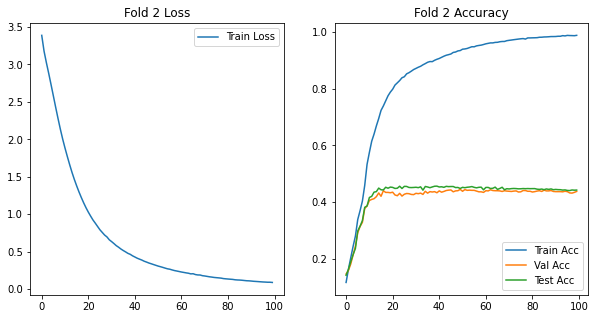

Processing fold 3/5...
Fold 3/5, Epoch 1: Train Loss=3.3918, Train Acc=0.1143, Val Acc=0.1477, Test Acc=0.1382
Fold 3/5, Epoch 2: Train Loss=3.1969, Train Acc=0.1543, Val Acc=0.1764, Test Acc=0.1662
Fold 3/5, Epoch 3: Train Loss=3.0488, Train Acc=0.2010, Val Acc=0.1967, Test Acc=0.1882
Fold 3/5, Epoch 4: Train Loss=2.9100, Train Acc=0.2330, Val Acc=0.2071, Test Acc=0.1967
Fold 3/5, Epoch 5: Train Loss=2.7630, Train Acc=0.2752, Val Acc=0.2287, Test Acc=0.2268
Fold 3/5, Epoch 6: Train Loss=2.6162, Train Acc=0.3228, Val Acc=0.2915, Test Acc=0.2961
Fold 3/5, Epoch 7: Train Loss=2.4627, Train Acc=0.3664, Val Acc=0.3098, Test Acc=0.3078
Fold 3/5, Epoch 8: Train Loss=2.3099, Train Acc=0.4059, Val Acc=0.3234, Test Acc=0.3221
Fold 3/5, Epoch 9: Train Loss=2.1634, Train Acc=0.4491, Val Acc=0.3378, Test Acc=0.3483
Fold 3/5, Epoch 10: Train Loss=2.0242, Train Acc=0.5115, Val Acc=0.3999, Test Acc=0.3992
Fold 3/5, Epoch 11: Train Loss=1.8995, Train Acc=0.5735, Val Acc=0.4097, Test Acc=0.4147
Fold 3/

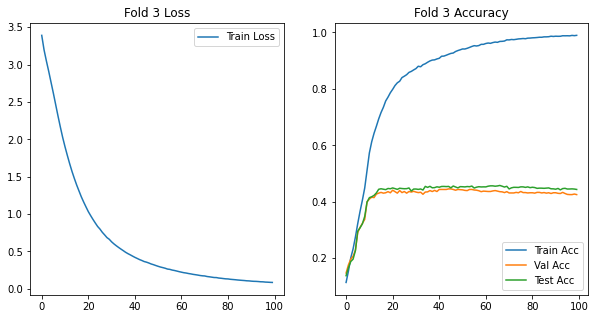

Processing fold 4/5...
Fold 4/5, Epoch 1: Train Loss=3.3935, Train Acc=0.1228, Val Acc=0.1503, Test Acc=0.1444
Fold 4/5, Epoch 2: Train Loss=3.1830, Train Acc=0.1730, Val Acc=0.1778, Test Acc=0.1809
Fold 4/5, Epoch 3: Train Loss=3.0305, Train Acc=0.2110, Val Acc=0.1883, Test Acc=0.1932
Fold 4/5, Epoch 4: Train Loss=2.8879, Train Acc=0.2385, Val Acc=0.2078, Test Acc=0.2196
Fold 4/5, Epoch 5: Train Loss=2.7445, Train Acc=0.2872, Val Acc=0.2209, Test Acc=0.2287
Fold 4/5, Epoch 6: Train Loss=2.5932, Train Acc=0.3294, Val Acc=0.2627, Test Acc=0.2849
Fold 4/5, Epoch 7: Train Loss=2.4437, Train Acc=0.3780, Val Acc=0.2837, Test Acc=0.3092
Fold 4/5, Epoch 8: Train Loss=2.2998, Train Acc=0.4026, Val Acc=0.2910, Test Acc=0.3172
Fold 4/5, Epoch 9: Train Loss=2.1550, Train Acc=0.4443, Val Acc=0.3158, Test Acc=0.3415
Fold 4/5, Epoch 10: Train Loss=2.0228, Train Acc=0.5035, Val Acc=0.3465, Test Acc=0.3733
Fold 4/5, Epoch 11: Train Loss=1.9033, Train Acc=0.5599, Val Acc=0.3889, Test Acc=0.4071
Fold 4/

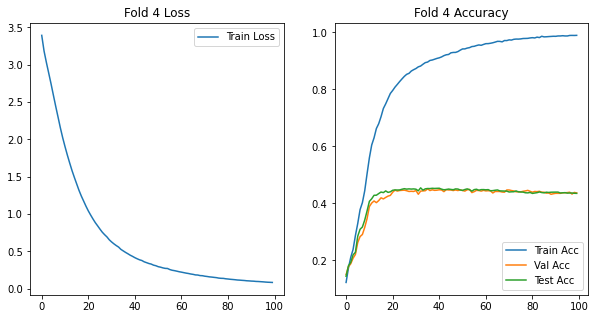

Processing fold 5/5...
Fold 5/5, Epoch 1: Train Loss=3.3852, Train Acc=0.1210, Val Acc=0.1334, Test Acc=0.1443
Fold 5/5, Epoch 2: Train Loss=3.1770, Train Acc=0.1699, Val Acc=0.1563, Test Acc=0.1669
Fold 5/5, Epoch 3: Train Loss=3.0264, Train Acc=0.1999, Val Acc=0.1752, Test Acc=0.1956
Fold 5/5, Epoch 4: Train Loss=2.8890, Train Acc=0.2307, Val Acc=0.1974, Test Acc=0.2110
Fold 5/5, Epoch 5: Train Loss=2.7460, Train Acc=0.2789, Val Acc=0.2189, Test Acc=0.2389
Fold 5/5, Epoch 6: Train Loss=2.5930, Train Acc=0.3318, Val Acc=0.2719, Test Acc=0.2977
Fold 5/5, Epoch 7: Train Loss=2.4460, Train Acc=0.3667, Val Acc=0.2844, Test Acc=0.3106
Fold 5/5, Epoch 8: Train Loss=2.2948, Train Acc=0.4007, Val Acc=0.2844, Test Acc=0.3161
Fold 5/5, Epoch 9: Train Loss=2.1530, Train Acc=0.4416, Val Acc=0.3144, Test Acc=0.3389
Fold 5/5, Epoch 10: Train Loss=2.0236, Train Acc=0.5066, Val Acc=0.3379, Test Acc=0.3612
Fold 5/5, Epoch 11: Train Loss=1.9016, Train Acc=0.5582, Val Acc=0.3862, Test Acc=0.4135
Fold 5/

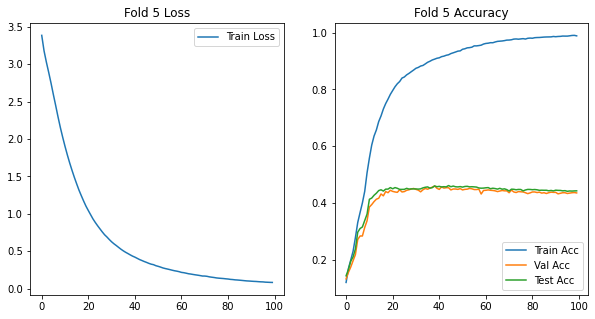

In [308]:
num_epochs = 100
k = 5
learning_rate = 0.3
hidden_dim = 1024

Model, Train_acc, Val_acc, Test_acc = k_fold_cross_validation(train_dataset, test_loader, k, num_epochs, batch_size, learning_rate, hidden_dim, device=device, shuffle=True)

In [309]:
Model

[MoannaModel(
   (fc1): Linear(in_features=13322, out_features=1024, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.3, inplace=False)
   (fc2): Linear(in_features=1024, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=1024, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.3, inplace=False)
   (fc2): Linear(in_features=1024, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=1024, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.3, inplace=False)
   (fc2): Linear(in_features=1024, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=1024, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.3, inplace=False)
   (fc2): Linear(in_features=1024, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=1024, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.3, inplace=False)
   (fc2): Linear(in_fe

In [310]:
Train_acc

[0.9896693561372838,
 0.9882489015918292,
 0.989675825818918,
 0.9893336515458226,
 0.98828125]

In [311]:
Val_acc

[0.43593229166666664,
 0.437140625,
 0.42548437499999997,
 0.4365833333333333,
 0.43583854166666663]

In [312]:
Test_acc

[0.44510099407783416,
 0.442009372356176,
 0.443734467533841,
 0.4352048302664975,
 0.44318091687817257]

In [313]:
TRAIN_acc = np.mean(Train_acc)
print(f"{TRAIN_acc:.4f}")

0.9890


In [314]:
VAL_acc = np.mean(Val_acc)
print(f"{VAL_acc:.4f}")

0.4342


In [315]:
TEST_acc = np.mean(Test_acc)
print(f"{TEST_acc:.4f}")

0.4418


In [316]:
def test_model(model, test_loader):
    model.eval()
    test_acc = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            test_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())

        test_acc /= len(test_loader)

    print(f"Test Accuracy: {test_acc:.4f}")

In [317]:
for i in range(5):
    test_model(Model[i], test_loader)

Test Accuracy: 0.4451
Test Accuracy: 0.4420
Test Accuracy: 0.4437
Test Accuracy: 0.4352
Test Accuracy: 0.4432


In [318]:
for inputs, labels in train_loader:
    outputs = Model[1](inputs)
    print(torch.argmax(outputs, dim=1))
    print(labels)

tensor([ 1, 21, 10,  1, 15, 21,  8,  7,  0, 27, 27, 27, 12, 15, 10, 20, 10,  5,
        15,  1, 27,  4, 21, 29,  1, 15, 16, 24, 13, 15, 25, 18,  9,  4,  6, 16,
        29, 27, 20, 29, 14,  1,  1,  1, 10, 21, 15, 29, 27, 10, 21, 27, 10,  8,
        26, 13, 10, 11,  0, 29,  1, 29, 11, 25, 27, 25,  8,  0, 16,  8, 20, 18,
         8, 18, 20, 18, 21, 15, 18, 15,  2, 10,  6, 12,  4,  0, 25, 12, 14,  2,
        24, 26, 16, 22,  1, 23, 27, 24,  7, 32, 15, 31,  0,  2,  4,  4,  7, 25,
         1,  7,  8, 31, 16,  2, 23, 16, 27, 16, 18, 19, 23,  0,  4, 10,  1, 29,
         0, 29, 15, 25,  6,  4,  8, 13, 30,  4, 24,  8, 11, 18,  8, 15, 18, 10,
        10,  2, 18, 16, 10,  1,  1, 27,  1,  4, 16, 27,  0, 13, 27, 21, 29, 15,
        15, 24, 18, 16, 26, 25, 27, 27,  6,  7,  8, 14, 19,  1, 19, 27, 13, 13,
         4, 16, 20, 16, 10, 27,  1, 21, 32, 29,  4,  7, 29,  1, 30, 25,  2, 15,
        10,  4, 25,  4,  8, 29, 14, 20, 18,  1,  1,  8, 10,  2, 15,  1,  7,  1,
        29, 22,  7, 29,  7,  1, 29, 24, 